# 1. Preliminary Data Analysis



In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url="https://proai-datasets.s3.eu-west-3.amazonaws.com/insurance_cross_sell.csv"

data=pd.read_csv(url)
df=data.copy()
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


The dataset contains the following variable:

* **id:** unique customer identifier (nominal categorical variable)
* **Gender:** Client's sex (nominal categorical variable)
* **Age:** Client's age (quantitative continuos variable)
* **Driving_License:** Nominal Categorical variable coded with 0 for clients who doesn't have driving license, 1 for the ones who have it
* **Region_Code:** unique code of the customer's region of residence
(nominal categorical variable)
* **Previously_insured:** Nominal Categorical variable coded with 1 if the customer already has an insured vehicle, 0 otherwise.
* **Vehicle_Age:** age of the customer's vehicle (quantitative continuos variable)
* **Vehicle_Damage:** Nominal Categorical variable coded with 1 if the customer has had accidents or damage to the vehicle in the past, 0 otherwise.
* **Annual_Premium:** annual amount of the insurance premium paid by the customer (quantitative continuos variable)
* **Policy_Sales_Channel:** channel used to sell the policy such email, telephone, in person (Nominal Categorical variable)
* **Vintage:** days from which the customer is insured with AssurePredict (quantitative continuos variable)
* **Response:** Nominal Categorical variable coded with 1 if the customer accepted the cross-sell proposal, 0 otherwise.

**1.1 Target Variable Distribution**

Since the target variable can assume only two value (0 for client who didn't accept the cross sell option and 1 for the ones who accepted), it is possibile to use a barchart to understand how the variable is distributed between the two classes.

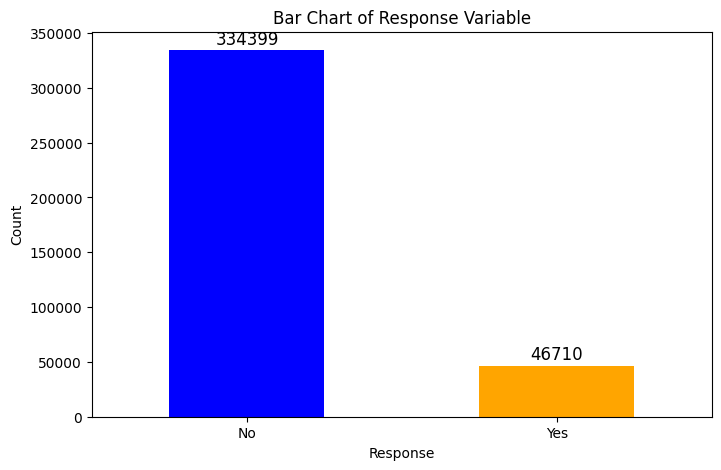

In [19]:
# 'Response' variable count
response_counts = data['Response'].value_counts()

# bar chart
plt.figure(figsize=(8, 5))
bars = response_counts.plot(kind='bar', color=['blue', 'orange'])
bars.set_xticklabels(['No', 'Yes'])
plt.title('Bar Chart of Response Variable')
plt.xlabel('Response')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Adding total for every class
for bar in bars.patches:
    plt.annotate(format(bar.get_height(), '.0f'),
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='center',
                 size=12, xytext=(0, 8),
                 textcoords='offset points')

plt.show()

The target variable show a very high imbalance.

**1.2 Target variable vs Annual Premium**

<ipython-input-20-3c0d2d2f341d>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No', 'Yes'])


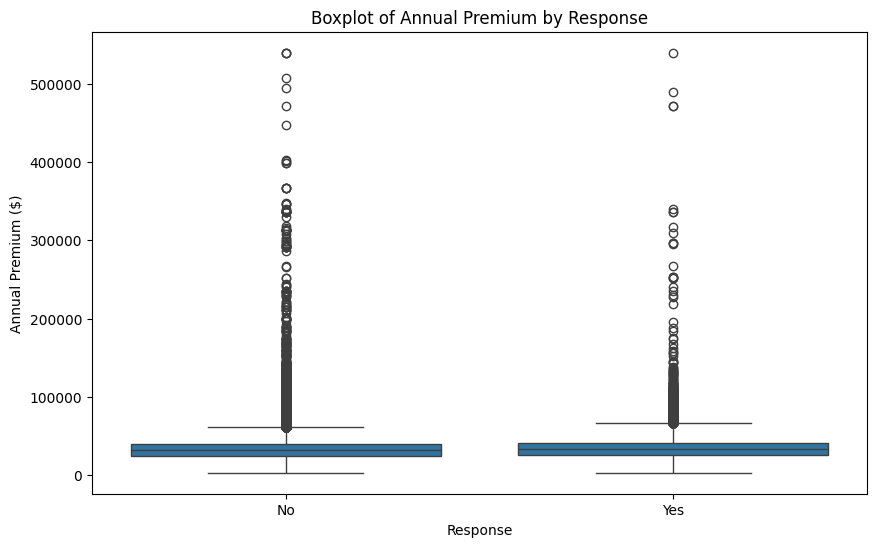

In [20]:
#boxplot 'Annual Premium' conditioned to 'Response'
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Response', y='Annual_Premium', data=data)
ax.set_xticklabels(['No', 'Yes'])
plt.title('Boxplot of Annual Premium by Response')
plt.xlabel('Response')
plt.ylabel('Annual Premium ($)')
plt.show()

Graphically, the two bar charts appear to be extremely similar, with the difference that the annual premium variable, conditioned on customers who have chosen not to accept the cross-selling option, presents a higher number of outliers. This is probably due to the high imbalance of the target variable in the two classes.

**1.3 Target variable vs Vehicle Age**

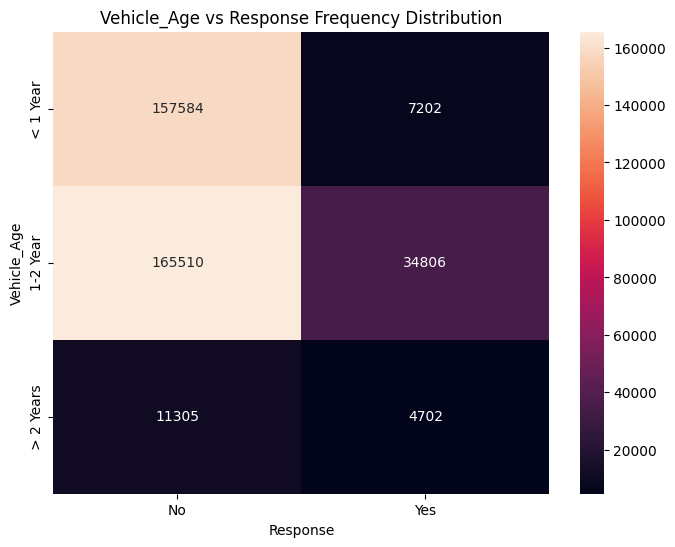

In [21]:
# Convert Vehicle Age in categorical
data['Vehicle_Age'] = pd.Categorical(data['Vehicle_Age'], categories=["< 1 Year", "1-2 Year", "> 2 Years"], ordered=True)

# Frequency Distribution
frequency_distribution = pd.crosstab(data['Vehicle_Age'], data['Response'])

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(frequency_distribution, annot=True, fmt="d",
            xticklabels=["No", "Yes"])
plt.title('Vehicle_Age vs Response Frequency Distribution')
plt.xlabel('Response')
plt.ylabel('Vehicle_Age')
plt.show()

As previously seen, the target variable is very imbalanced, infact the heatmap is dominate by negative respose to cross sell proposal.

* **Vehicles < 1 year:**  This category has a significant number of responses, mostly negative (more than 95%). Clients in this category are definitely not interested in the proposal.

* **Vehicles 1-2 years:** This category has the most responses overall, for both responses. In particular, clients with vehicles 1-2 years old have a relatively high number of positive responses, indicating a higher likelihood in subscribing an insurance policy.

* **Vehicles > 2 years:** Although, the percentage of positive responses (near 30%) is the highest registered, this could be due to chance considering that this category has the least responses overall.

**1.5 Correlation Matrix**

To analyze how the features are related to the target variable and to each other, it is possible to use a correlation matrix.

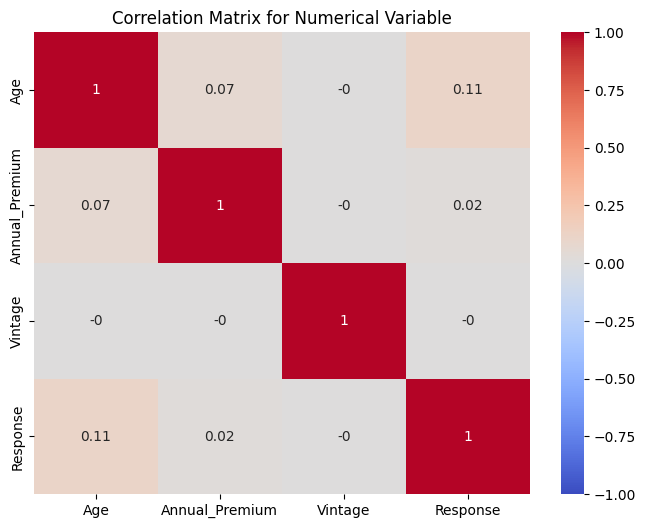

In [22]:
df_num=df.drop(['id','Gender','Driving_License','Region_Code',
                'Previously_Insured','Vehicle_Age','Vehicle_Damage',
                'Policy_Sales_Channel'], axis=1)

df_corr=df_num.corr().values.round(2)

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, xticklabels=df_num.columns, yticklabels=df_num.columns)
plt.title('Correlation Matrix for Numerical Variable')
plt.show()

Correlation Matrix evaluated on the quantitative variables suggests no correlation between these features and target variable.

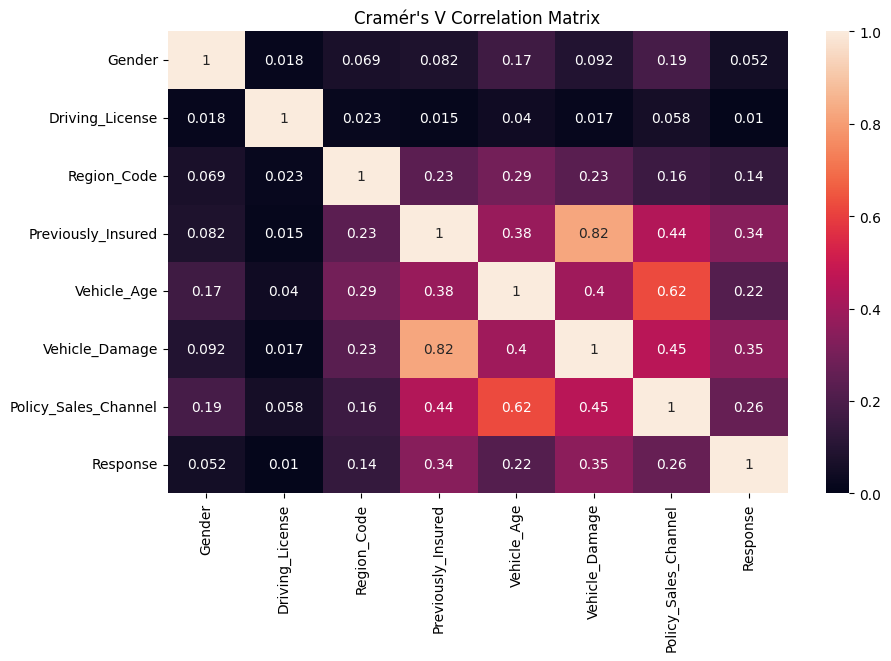

In [23]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Categorical variable
categorical_columns = ['Gender','Driving_License','Region_Code','Previously_Insured','Vehicle_Age','Vehicle_Damage',
                       'Policy_Sales_Channel','Response']
#Cramers matrix
cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_columns), len(categorical_columns))), index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:
            cramers_v_matrix.loc[col1, col2] = cramers_v(data[col1], data[col2])
        else:
            cramers_v_matrix.loc[col1, col2] = 1

plt.figure(figsize=(10, 6))
sns.heatmap(cramers_v_matrix, annot=True, vmin=0, vmax=1)
plt.title("Cramér\'s V Correlation Matrix")
plt.show()

**Previously_Insured** and **Vehicle_Damage** are the most correlated variable with the target. They show also a high correlation between them and this could bring multicollinearity problem.

**Policy_Sales_Channel** and **Vehicle_Age** also show a correlation (not high) with the target.



# 2. Preprocessing

Since the dataset contains non-numeric variables, in order to correctly create a model it is necessary to encode the following variables.

**Gender:**

*   Male = 0
*   Female =1

**Vehicle Age:**

*   \<1 Year = 0
*   1-2 Year = 1
*   \>2 Year = 2

**Vehicle Damage:**

*   No = 0
*   Yes = 1

In [24]:
# Gender Mapping
mapping = {"Male":0, "Female":1}
df["Gender"] = df["Gender"].map(mapping)

#Vehicle Age Mapping
mapping = {"< 1 Year":0, "1-2 Year":1, "> 2 Years":2}
df["Vehicle_Age"] = df["Vehicle_Age"].map(mapping)

#Vehicle Damage Mapping
mapping = {"No":0, "Yes":1}
df["Vehicle_Damage"] = df["Vehicle_Damage"].map(mapping)

For Nominal Categorical variable let's apply OneHotEncoder

In [25]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

#Feature subdivision
#ordinal e binary variable will be not affected by preprocessing
categorical_features = ['Gender','Region_Code','Policy_Sales_Channel']
numerical_features = ['Age','Annual_Premium','Vintage']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough')

In [26]:
#Confusion matrix function
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    df_cm=pd.DataFrame(cm, index=['Negative','Positive'],
                       columns=['Predicted Negative','Predicted Positive'])

    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.show()

# 3. Class Imbalance Management

**3.1 class_weight='balanced'**

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report , precision_score

X=df.drop(['id','Response'], axis=1)
y=df['Response']

RANDOM_SEED=2

#Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

#Applying Preprocessor
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


#Model fit
lr=LogisticRegression(class_weight='balanced',solver='liblinear',penalty='l1',random_state=RANDOM_SEED)

lr.fit(X_train, y_train)

#Evaluate y with model
y_pred_train=lr.predict(X_train)
y_pred_test=lr.predict(X_test)

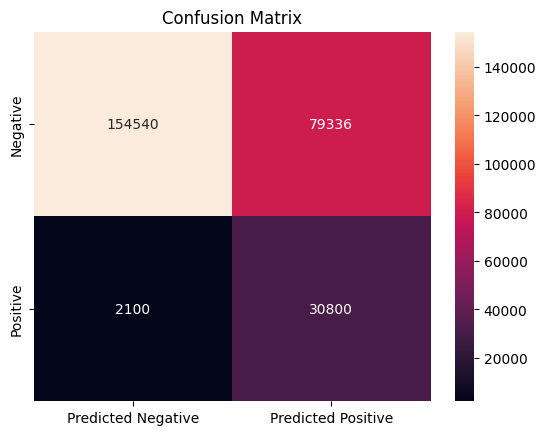

              precision    recall  f1-score   support

           0       0.99      0.66      0.79    233876
           1       0.28      0.94      0.43     32900

    accuracy                           0.69    266776
   macro avg       0.63      0.80      0.61    266776
weighted avg       0.90      0.69      0.75    266776



In [28]:
plot_confusion_matrix(y_train,y_pred_train)
print(classification_report(y_train, y_pred_train))

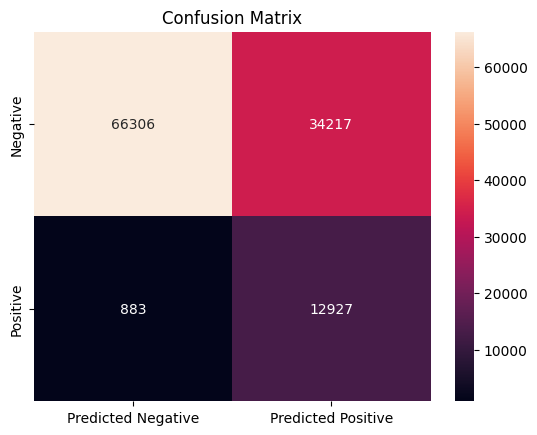

              precision    recall  f1-score   support

           0       0.99      0.66      0.79    100523
           1       0.27      0.94      0.42     13810

    accuracy                           0.69    114333
   macro avg       0.63      0.80      0.61    114333
weighted avg       0.90      0.69      0.75    114333



In [29]:
plot_confusion_matrix(y_test,y_pred_test)
print(classification_report(y_test, y_pred_test))

Looking at the classification report on the train set and test set, the model behaves in the same way.
Referring to the recall metric, we realize that the model is able to correctly classify 94% of the positive answers and 66% of the negative ones.

Therefore, in the face of a 6% loss on insurance policies, a significant skimming of customers is obtained.

The model obtained has the same accuracy on both train and test set.

**3.2 Oversampling**

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

#split dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

#resampling test set
X_train, y_train = oversample.fit_resample(X_train, y_train)

#Applying Preprocessor
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

#Model fit
lr=LogisticRegression(random_state=RANDOM_SEED, solver='liblinear', C=0.1, penalty='l1')

lr.fit(X_train, y_train)

#Evaluate y with model
y_pred_train=lr.predict(X_train)
y_pred_test=lr.predict(X_test)

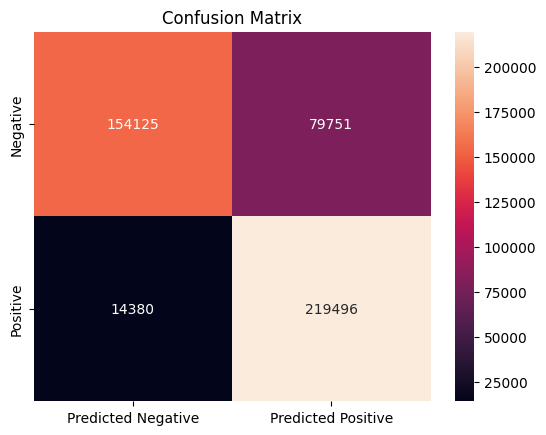

              precision    recall  f1-score   support

           0       0.91      0.66      0.77    233876
           1       0.73      0.94      0.82    233876

    accuracy                           0.80    467752
   macro avg       0.82      0.80      0.79    467752
weighted avg       0.82      0.80      0.79    467752



In [ ]:
plot_confusion_matrix(y_train,y_pred_train)
print(classification_report(y_train, y_pred_train))

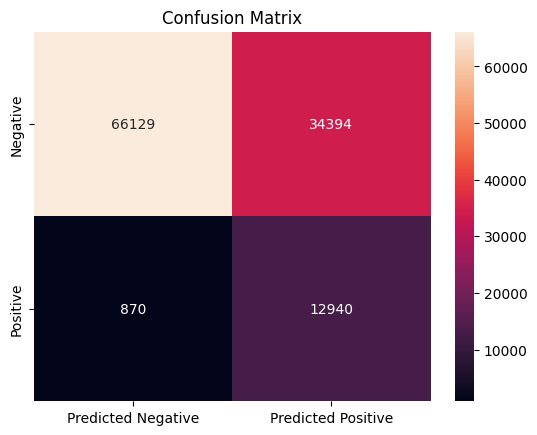

              precision    recall  f1-score   support

           0       0.99      0.66      0.79    100523
           1       0.27      0.94      0.42     13810

    accuracy                           0.69    114333
   macro avg       0.63      0.80      0.61    114333
weighted avg       0.90      0.69      0.75    114333



In [ ]:
plot_confusion_matrix(y_test,y_pred_test)
print(classification_report(y_test, y_pred_test))

Applying the oversamplig to the test set, the accuracy on this set has increased, however the recall values ​​for both positive and negative values ​​remain unchanged.

No performance changes on the test set were found. The increase in accuracy on the training set but not on the test set could be a symptom of overfitting

**3.3 Undersampling**

In [ ]:
#define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

#split dataset
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

#resampling train set
X_train, y_train = undersample.fit_resample(X_train, y_train)

#Applying Preprocessor
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

#Model fit
lr=LogisticRegression(random_state=RANDOM_SEED, solver='liblinear', penalty='l1', C=0.1)

lr.fit(X_train, y_train)

#Evaluate y with model
y_pred_train=lr.predict(X_train)
y_pred_test=lr.predict(X_test)

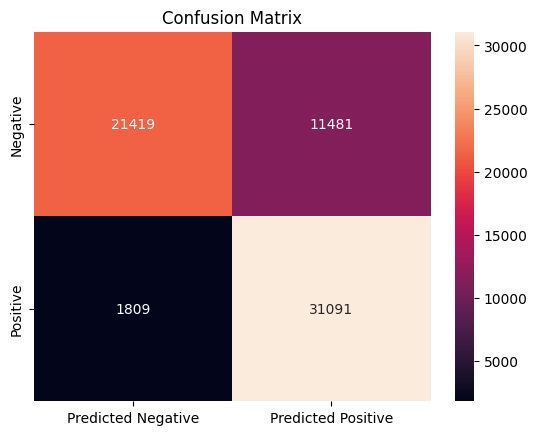

              precision    recall  f1-score   support

           0       0.92      0.65      0.76     32900
           1       0.73      0.95      0.82     32900

    accuracy                           0.80     65800
   macro avg       0.83      0.80      0.79     65800
weighted avg       0.83      0.80      0.79     65800



In [ ]:
plot_confusion_matrix(y_train,y_pred_train)
print(classification_report(y_train, y_pred_train))

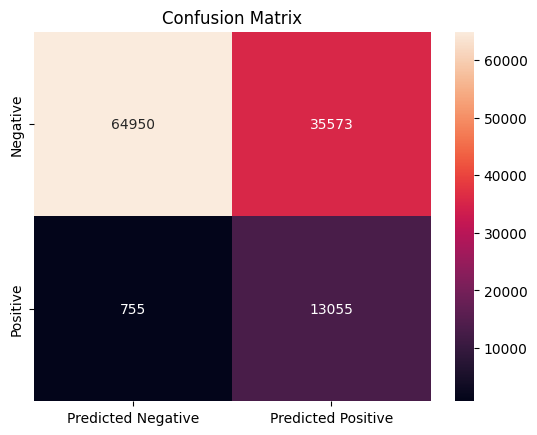

              precision    recall  f1-score   support

           0       0.99      0.65      0.78    100523
           1       0.27      0.95      0.42     13810

    accuracy                           0.68    114333
   macro avg       0.63      0.80      0.60    114333
weighted avg       0.90      0.68      0.74    114333



In [ ]:
plot_confusion_matrix(y_test,y_pred_test)
print(classification_report(y_test, y_pred_test))

No substantial differences in the model's performance appear applying undersampling compared to oversampling.

**3.4 Oversampling and Undersampling combined**

In [ ]:
#split dataset
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.2)
# fit and apply the transform
X_train, y_train = over.fit_resample(X_train, y_train)
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5)
# fit and apply the transform
X_train, y_train = under.fit_resample(X_train, y_train)

#Applying Preprocessor
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

#Model fit
lr=LogisticRegression(random_state=RANDOM_SEED, solver='liblinear', penalty='l1', C=0.1)

lr.fit(X_train, y_train)

#Evaluate y with model
y_pred_train=lr.predict(X_train)
y_pred_test=lr.predict(X_test)

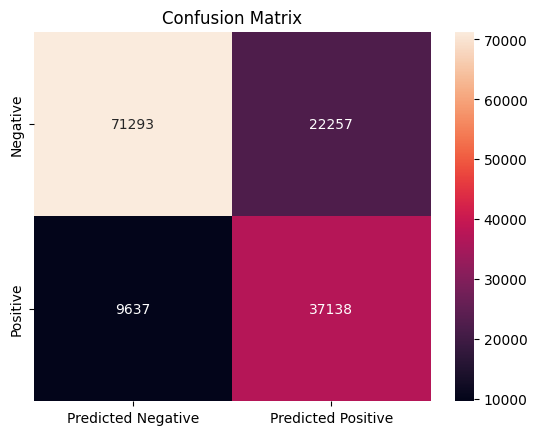

              precision    recall  f1-score   support

           0       0.88      0.76      0.82     93550
           1       0.63      0.79      0.70     46775

    accuracy                           0.77    140325
   macro avg       0.75      0.78      0.76    140325
weighted avg       0.80      0.77      0.78    140325



In [ ]:
plot_confusion_matrix(y_train,y_pred_train)
print(classification_report(y_train, y_pred_train))

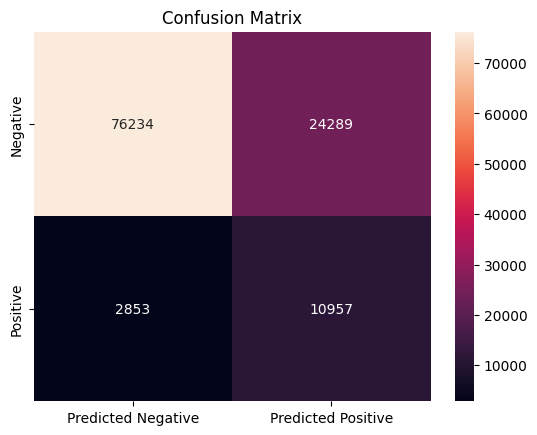

              precision    recall  f1-score   support

           0       0.96      0.76      0.85    100523
           1       0.31      0.79      0.45     13810

    accuracy                           0.76    114333
   macro avg       0.64      0.78      0.65    114333
weighted avg       0.89      0.76      0.80    114333



In [ ]:
plot_confusion_matrix(y_test,y_pred_test)
print(classification_report(y_test, y_pred_test))

The accuracy on the test set is extremely similar to the results obtained previously (balanced classweight, oversampling, undersampling). The main difference in the metrics is related to the recall parameter. Both on the training and test sets there has been a change in the distribution. The model is able to better filter out customers who are not interested (11% more than previous models) but it gives up some of the interested customers (16% less interested customers who are classified as such).

# 4. Predictive Model

During the analysis it emerged that the features that show correlation with the target variable are Policy_Sales_Channel, Region_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage. Let's try to simplify the model removing all the other features.

Since the initial analysis revealed a high correlation coefficient between variables Previously_Insured and Vehicle_Damage, let's verify that there are no multicollinearity problems.



In [44]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_copy=df.drop(['id','Gender','Age','Driving_License',
           'Annual_Premium',
           'Vintage','Response'], axis=1)

X_copy = sm.add_constant(X_copy)

vif_data = pd.DataFrame()
vif_data['Feature'] = X_copy.columns
vif_data['VIF'] = [round(variance_inflation_factor(X_copy.values, i),2) for i in range(X_copy.shape[1])]

print(vif_data)

                Feature    VIF
0                 const  26.70
1           Region_Code   1.00
2    Previously_Insured   3.15
3           Vehicle_Age   1.63
4        Vehicle_Damage   3.20
5  Policy_Sales_Channel   1.44


Since all the VIF are lower than 5, no multicollinearity problema are found.

The oversampling, undersampling and combined over/undersampling strategy did not bring substancial model performance improvement compared to the use of balanced class weight.

In [30]:
from sklearn.model_selection import KFold
#Batch creation
kf=KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

#Feature subdivision
categorical_features = ['Policy_Sales_Channel','Region_Code']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough')

#Features selection
X=df.drop(['id','Gender','Age','Driving_License',
           'Annual_Premium',
           'Vintage','Response'], axis=1)
y=df['Response']


kf.get_n_splits(X)

train_score=[]
test_score=[]

for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    #Applying Preprocessor
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)


    #Model fit
    lr=LogisticRegression(class_weight='balanced', C=0.1, solver='liblinear',penalty='l1',random_state=RANDOM_SEED)

    lr.fit(X_train, y_train)

    acc_test=accuracy_score(y_test, lr.predict(X_test))
    acc_train=accuracy_score(y_train, lr.predict(X_train))

    train_score.append(acc_train)
    test_score.append(acc_test)

scores=pd.DataFrame({'train':train_score, 'test':test_score})
print(scores)

      train      test
0  0.687960  0.686298
1  0.687573  0.686757
2  0.692588  0.689683
3  0.692089  0.699811
4  0.692995  0.690374


Using the cross validation technique, it can be observed that the accuracy is extremely similar between the various training and test sets. The model does not suffer from overfitting.

In [34]:
#Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

#Applying Preprocessor
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


#Model fit
lr=LogisticRegression(class_weight='balanced',C=0.1,solver='liblinear',penalty='l1',random_state=RANDOM_SEED)

lr.fit(X_train, y_train)

#Evaluate y with model
y_pred_train=lr.predict(X_train)
y_pred_test=lr.predict(X_test)

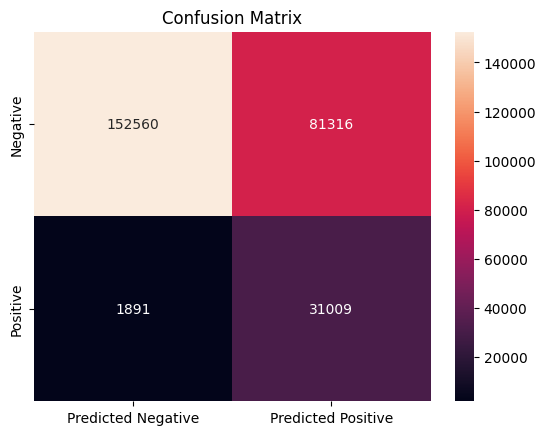

              precision    recall  f1-score   support

           0       0.99      0.65      0.79    233876
           1       0.28      0.94      0.43     32900

    accuracy                           0.69    266776
   macro avg       0.63      0.80      0.61    266776
weighted avg       0.90      0.69      0.74    266776



In [35]:
plot_confusion_matrix(y_train,y_pred_train)
print(classification_report(y_train, y_pred_train))

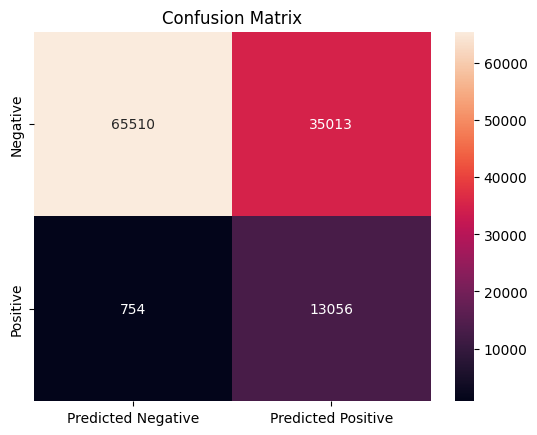

              precision    recall  f1-score   support

           0       0.99      0.65      0.79    100523
           1       0.27      0.95      0.42     13810

    accuracy                           0.69    114333
   macro avg       0.63      0.80      0.60    114333
weighted avg       0.90      0.69      0.74    114333



In [36]:
plot_confusion_matrix(y_test,y_pred_test)
print(classification_report(y_test, y_pred_test))

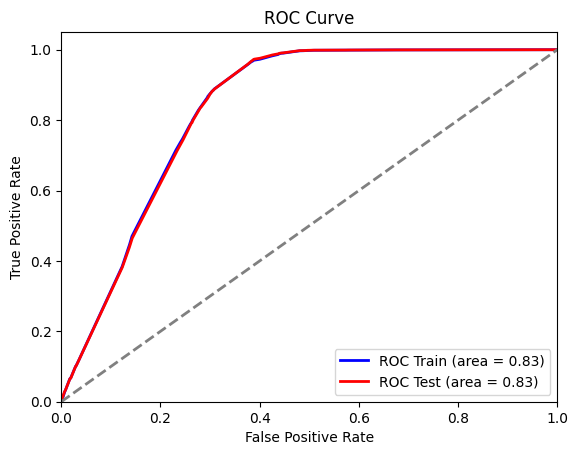

In [ ]:
from sklearn.metrics import roc_curve, auc

y_proba_train=lr.predict_proba(X_train)[:, 1]
y_proba_test=lr.predict_proba(X_test)[:, 1]

# Evaluate false positive ratio and true positive ratio
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)


# Roc Curve
plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'ROC Train (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'ROC Test (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

An AUC value of 0.83 for both datasets (train and test) indicates that the model has a good performance in distinguish between positive and negative classes.

The ROC curves for the train and test sets are very similar, suggesting is not overfitted.

As seen previously, the model is able to filter out 65% of non-interested customers, in face off 6% of customers interested in the offer who are classified as false negatives.

Since the goal is to optimize the marketing campaign by contacting only customers who are likely to accept the offer, let's see if changing the model threshold can filter out a greater percentage of uninterested customers.

In [47]:
#probability
y_proba_test = lr.predict_proba(X_test)[:, 1]
#new threshold
threshold = 0.6
#update y predict
y_pred_new = (y_proba_test >= threshold).astype(int)

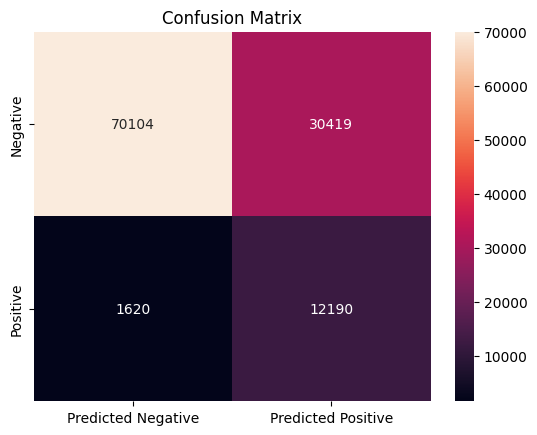

              precision    recall  f1-score   support

           0       0.98      0.70      0.81    100523
           1       0.29      0.88      0.43     13810

    accuracy                           0.72    114333
   macro avg       0.63      0.79      0.62    114333
weighted avg       0.89      0.72      0.77    114333



In [48]:
plot_confusion_matrix(y_test,y_pred_new)
print(classification_report(y_test, y_pred_new))

By increasing the threshold from 0.5 to 0.6, the percentage of uninterested customers that the model can correctly identify increased by 5%, but it must be accepted that a greater percentage of potentially interested customers will be classified as uninterested. With the new threshold, the percentage of interested customers classified as such decreased from 95% to 88%.

For a correct tuning of the threshold, a cost-benefit analysis would be necessary to identify the optimum point between the expenditure for the marketing campaign and the possible economic loss due to not reaching interested potential customers.